In [13]:
import numpy as np
import pandas as pd
import cv2
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import time, random
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3, Xception, InceptionResNetV2,DenseNet121, MobileNet, MobileNetV2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
files_path = '/content/drive/MyDrive/COVID_DATASET'
files_path = pathlib.Path(files_path)
files_path

PosixPath('/content/drive/MyDrive/COVID_DATASET')

In [4]:
images_dict = {
    'covid': list(files_path.glob('COVID/*')),
    'pneumonia': list(files_path.glob('PNEUMONIA/*')),
    'healthy': list(files_path.glob('HEALTHY/*'))
}
labels_dict = {
    'covid': 0,
    'pneumonia': 1,
    'healthy' : 2
}

In [5]:
IMAGE_SHAPE = (224, 224)
X, y = [], []
for name, images in images_dict.items():
    for image in images:
        img = cv2.imread(str(image), 1)
        resized_img = cv2.resize(img, dsize=IMAGE_SHAPE)
        blurred_img = cv2.GaussianBlur(resized_img, ksize=(3, 3), sigmaX=0.5, sigmaY=0.7,
                                       borderType=cv2.BORDER_CONSTANT)
        hsv_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2HSV)
        h, s, v = hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2]
        value = 10
        limit = 255 - value
        v[v > limit] = 255
        v[v <= limit] += value
        hsv_img_new = cv2.merge((h, s, v))
        img_brightness = cv2.cvtColor(hsv_img_new, cv2.COLOR_HSV2RGB)
        img_brightness_gray = cv2.cvtColor(img_brightness, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
        img_hist_gray = clahe.apply(img_brightness_gray)
        img_hist = cv2.cvtColor(img_hist_gray, cv2.COLOR_GRAY2RGB)
        X.append(img_hist)
        y.append(labels_dict[name])

X = np.array(X)
y = np.array(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape

(1128, 224, 224, 3)

In [7]:
X_train = X_train / 255
X_test = X_test / 255

In [8]:
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2
)

In [15]:
def model_1(img_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16,3,padding='same',activation='relu',input_shape=(img_shape+(3,))),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(3,activation='softmax')
    ])
    return model

def model_2(img_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu',input_shape=(img_shape+(3,))),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128,activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def model_3(img_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu',input_shape=(img_shape+(3,))),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128,3,padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model


def inceptionv3(img_shape):
    model_inception = InceptionV3(include_top=False,weights='imagenet',input_shape=(img_shape+(3,)))
    for layer in model_inception.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_inception,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.Dense(3,activation='softmax')
    ])
    return model

def mobilenet(img_shape):
    model_mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=(img_shape + (3,)))
    for layer in model_mobilenet.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_mobilenet,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def densenet121(img_shape):
    model_densenet121 = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_shape + (3,)))
    for layer in model_densenet121.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_densenet121,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def xception(img_shape):
    model_xception = Xception(include_top=False, weights='imagenet', input_shape=(img_shape + (3,)))
    for layer in model_xception.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_xception,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

def mobilenetv2(img_shape):
    model_mobilenetv2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_shape + (3,)))
    for layer in model_mobilenetv2.layers:
        layer.trainable = False
    model = tf.keras.Sequential([
        model_mobilenetv2,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

In [17]:
model = densenet121(img_shape=(224,224))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               25690624  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 32,729,667
Trainable params: 25,692,163
Non-trainable params: 7,037,504
_________________________________________________________________


In [18]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [19]:
start_time = time.time()
train = model.fit(data_augmentation.flow(X_train, y_train,batch_size=32), epochs=100)
end_time = time.time()

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


36/36 [==============================] - 52s 424ms/step - loss: 7.2219 - accuracy: 0.7234
Epoch 2/100
36/36 [==============================] - 15s 402ms/step - loss: 0.8860 - accuracy: 0.8502
Epoch 3/100
36/36 [==============================] - 15s 401ms/step - loss: 0.9509 - accuracy: 0.8590
Epoch 4/100
36/36 [==============================] - 15s 402ms/step - loss: 0.7426 - accuracy: 0.8785
Epoch 5/100
36/36 [==============================] - 14s 398ms/step - loss: 0.6870 - accuracy: 0.8652
Epoch 6/100
36/36 [==============================] - 15s 400ms/step - loss: 0.5467 - accuracy: 0.8901
Epoch 7/100
36/36 [==============================] - 14s 398ms/step - loss: 0.5421 - accuracy: 0.8706
Epoch 8/100
36/36 [==============================] - 15s 406ms/step - loss: 0.4482 - accuracy: 0.8794
Epoch 9/100
36/36 [==============================] - 15s 402ms/step - loss: 0.3403 - accuracy: 0.9060
Epoch 10/100
36/36 [==============================] - 15s 405ms/step - loss: 0.3175 - accuracy

In [20]:
training_time = end_time - start_time
training_time

1536.0035891532898

In [21]:
test = model.evaluate(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


12/12 [==============================] - 7s 359ms/step - loss: 0.1650 - accuracy: 0.9335


In [22]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(i) for i in y_pred]
y_pred = np.array(y_pred)

In [23]:
# Classification Report
cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
df_cr = pd.DataFrame(cr).transpose()
df_cr = df_cr.rename(index={'0': 'Covid-19', '1': 'Pneumonia','2':'Healthy'})
df_cr

,precision,recall,f1-score,support
Covid-19,0.949153,0.854962,0.899598,131.000000
Pneumonia,0.874126,0.954198,0.912409,131.000000
Healthy,0.991304,1.000000,0.995633,114.000000
accuracy,0.933511,0.933511,0.933511,0.933511
macro avg,0.938194,0.936387,0.935880,376.000000
weighted avg,0.935793,0.933511,0.933179,376.000000


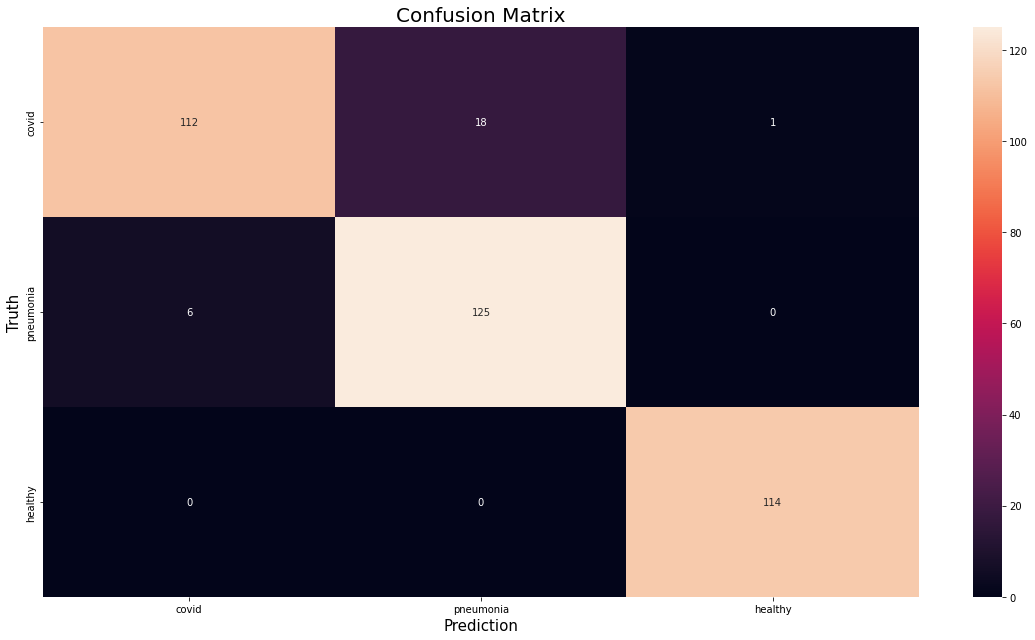

In [24]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[i for i, j in labels_dict.items()], columns=[i for i, j in labels_dict.items()])
fig = plt.figure(figsize=(16, 9))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.tight_layout()
plt.show()

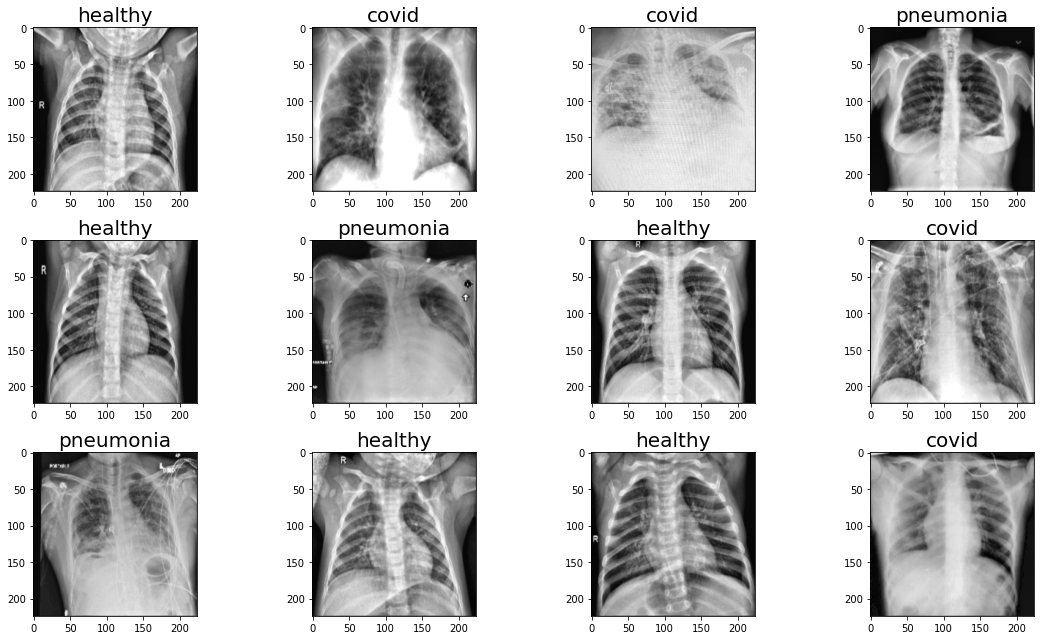

In [26]:
labels = list(map(lambda x: 'a', range(0, len(y_test))))
first_labels = [i for i, j in labels_dict.items()]
for i in range(len(y_test)):
    if y_test[i] == y_pred[i]:
        labels[i] = first_labels[y_pred[i]]
    elif y_test[i] == 0 and y_pred[i] == 1:
        labels[i] = 'True: Covid-19\nPredict: Pneumonia'
    elif y_test[i] == 0 and y_pred[i] == 2:
        labels[i] = 'True: Covid-19\nPredict: Healthy'
    elif y_test[i] == 1 and y_pred[i] == 0:
        labels[i] = 'True: Pneumonia\nPredict: Covid-19'
    elif y_test[i] == 1 and y_pred[i] == 2:
        labels[i] = 'True: Pneumonia\nPredict: Healthy'
    elif y_test[i] == 2 and y_pred[i] == 0:
        labels[i] = 'True: Healthy\nPredict: Covid-19'
    elif y_test[i] == 2 and y_pred[i] == 1:
        labels[i] = 'True: Healthy\nPredict: Pneumonia'

r = 3
c = 4
fig, axes = plt.subplots(r, c, figsize=(16, 9))
for i in range(0, r):
    for j in range(0, c):
        rand = random.randint(0, len(X_test))
        axes[i, j].imshow(X_test[rand])
        axes[i, j].set_title(labels[rand], fontsize=20)
plt.tight_layout()
plt.show()

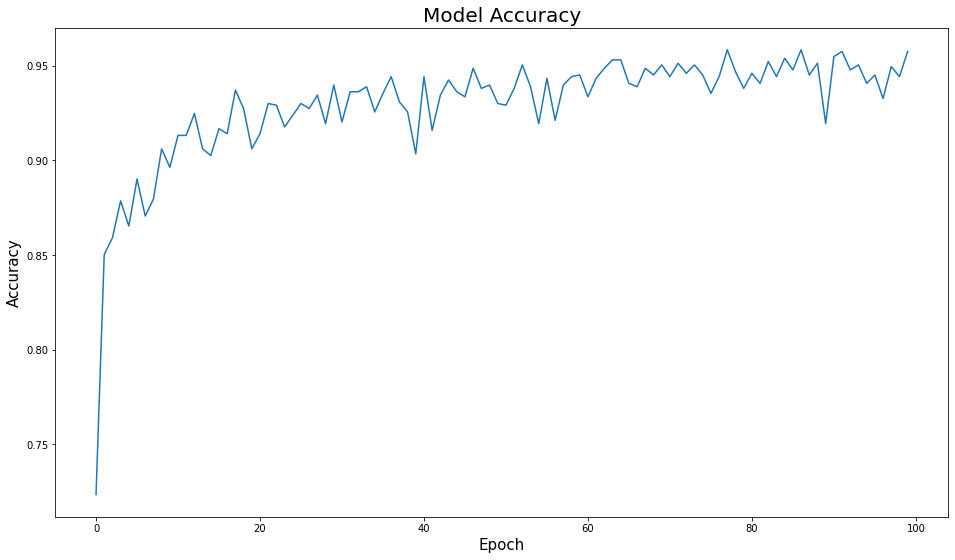

In [27]:
n_epochs = len(train.history['accuracy'])
fig_acc = plt.figure(0, figsize=(16, 9))
plt.plot(range(n_epochs), train.history['accuracy'])
plt.title('Model Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.show()

Text(0, 0.5, 'Loss')

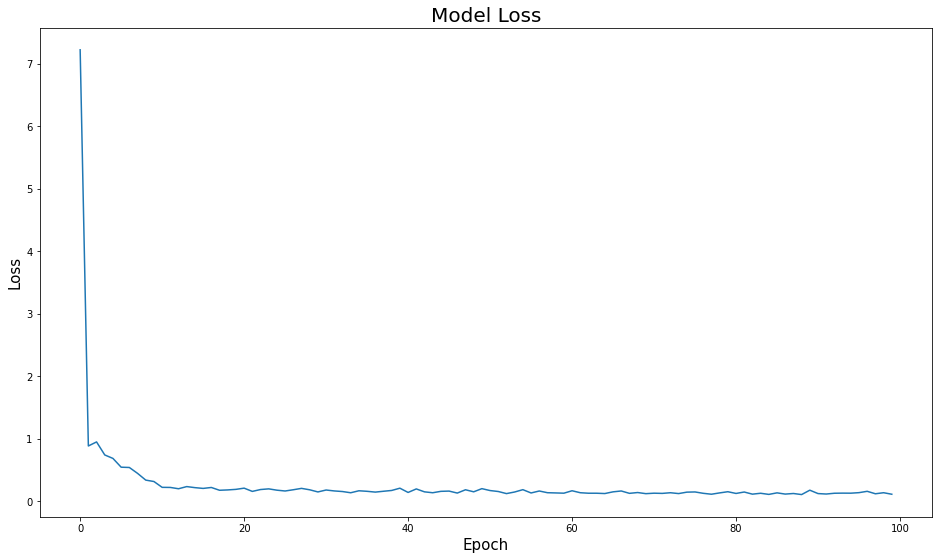

In [28]:
fig_loss = plt.figure(1, figsize=(16, 9))
plt.plot(range(n_epochs), train.history['loss'])
plt.title('Model Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)

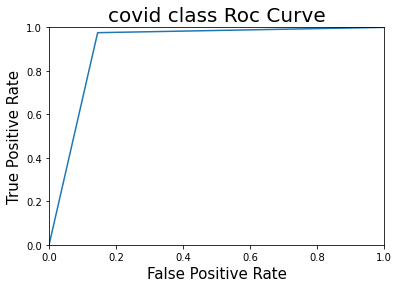

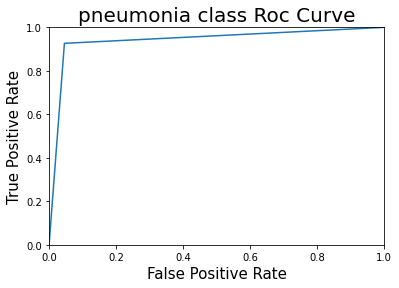

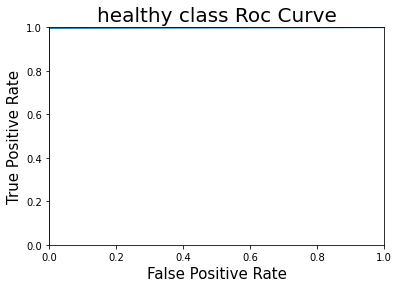

In [29]:
roc_labels = [['covid_test','covid_pred'],['pneumonia_test','pneumonia_pred'],['healthy_test','healthy_pred']]

iteration = 0

for i,j in roc_labels:
    globals()[i] = np.where(y_test == iteration,0,1)
    globals()[j] = np.where(y_pred == iteration,0,1)
    fpr, tpr, _ = roc_curve(globals()[i], globals()[j])
    fig,ax = plt.subplots()
    ax.plot(fpr,tpr)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title('{} class Roc Curve'.format(i.split('_')[0]), fontsize=20)
    ax.set_xlabel('False Positive Rate', fontsize=15)
    ax.set_ylabel('True Positive Rate', fontsize=15)
    iteration += 1